In [1]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime

c:\Users\berna\sentiment_analysis\sentiment_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
today = datetime.today().strftime('%d-%m-%Y')
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

In [3]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

c:\Users\berna\sentiment_analysis\sentiment_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # FinBERT returns scores in the order [positive, negative, neutral]
    positive_score = probabilities[0, 0].item()
    negative_score = probabilities[0, 1].item()
    neutral_score = probabilities[0, 2].item()
    
    return positive_score, negative_score, neutral_score

In [5]:
def analyze_sentiment(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Initialize lists to store results
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    overall_sentiments = []
    
    # Perform sentiment analysis on each title
    for title in tqdm(df['title'], desc="Analyzing sentiment"):
        pos, neg, neu = get_sentiment_scores(title)
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
        
        # Determine overall sentiment
        max_score = max(pos, neg, neu)
        if max_score == pos:
            overall_sentiments.append("Positive")
        elif max_score == neg:
            overall_sentiments.append("Negative")
        else:
            overall_sentiments.append("Neutral")
    
    # Add results to the dataframe
    df['positive_score'] = positive_scores
    df['negative_score'] = negative_scores
    df['neutral_score'] = neutral_scores
    df['overall_sentiment'] = overall_sentiments
    
    return df

In [6]:
csv_file = r'C:\Users\berna\sentiment_analysis\br_market\data\raw\brazilian_stocks_03-10-2024_news.csv'
results_df = analyze_sentiment(csv_file)

Analyzing sentiment: 100%|██████████| 3022/3022 [04:36<00:00, 10.91it/s]


In [7]:
results_df.to_csv(f'brazilian_stocks_news_with_finbert_sentiment_{today}.csv', index=False)
print(f"Analysis completed. Results saved to 'brazilian_stocks_news_with_finbert_sentiment_{today}.csv'")


Analysis completed. Results saved to 'brazilian_stocks_news_with_finbert_sentiment_03-10-2024.csv'


In [8]:
sentiment_counts = results_df['overall_sentiment'].value_counts()
print("\nOverall Sentiment Distribution:")
print(sentiment_counts)



Overall Sentiment Distribution:
overall_sentiment
Neutral     1951
Positive     652
Negative     419
Name: count, dtype: int64


In [9]:
ticker_sentiment = results_df.groupby('company').agg({
    'positive_score': 'mean',
    'negative_score': 'mean',
    'neutral_score': 'mean'
}).sort_values('positive_score', ascending=False)

print("\nAverage Sentiment Scores by Ticker:")
print(ticker_sentiment)


Average Sentiment Scores by Ticker:
                                         positive_score  negative_score  \
company                                                                   
Sigma Lithium Corporation                      0.469698        0.050451   
Embraer S.A. ADR                               0.440943        0.098073   
Azul S.A. ADR                                  0.388063        0.158895   
Inter & Co Inc                                 0.376123        0.078430   
Atlas Lithium Corporation                      0.373561        0.026926   
Braskem S.A. ADR                               0.368051        0.166844   
CI&T Inc                                       0.332359        0.137608   
PagSeguro Digital Ltd                          0.296650        0.105514   
Petroleo Brasileiro S.A. Petrobras ADR         0.290763        0.250260   
Vale S.A. ADR                                  0.269949        0.142654   
BRF S.A. ADR                                   0.267519        


Overall sentiment distribution plot saved as 'overall_sentiment_distribution_finbert.png'


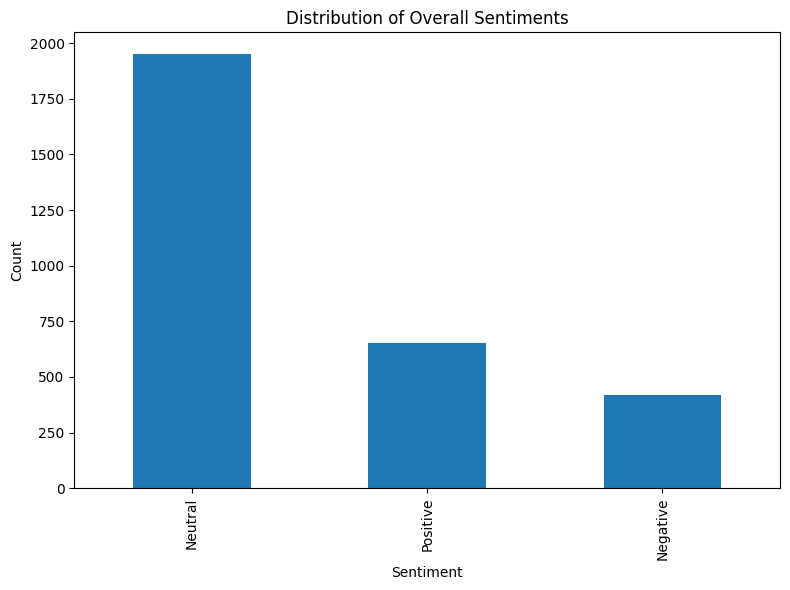

In [10]:

# Overall sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Overall Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('overall_sentiment_distribution_finbert.png')
print("\nOverall sentiment distribution plot saved as 'overall_sentiment_distribution_finbert.png'")

In [11]:
import seaborn as sns 

C:\Users\berna\AppData\Local\Temp\ipykernel_17472\2260860894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_positive.index, y=top_positive.values, palette='YlOrRd')


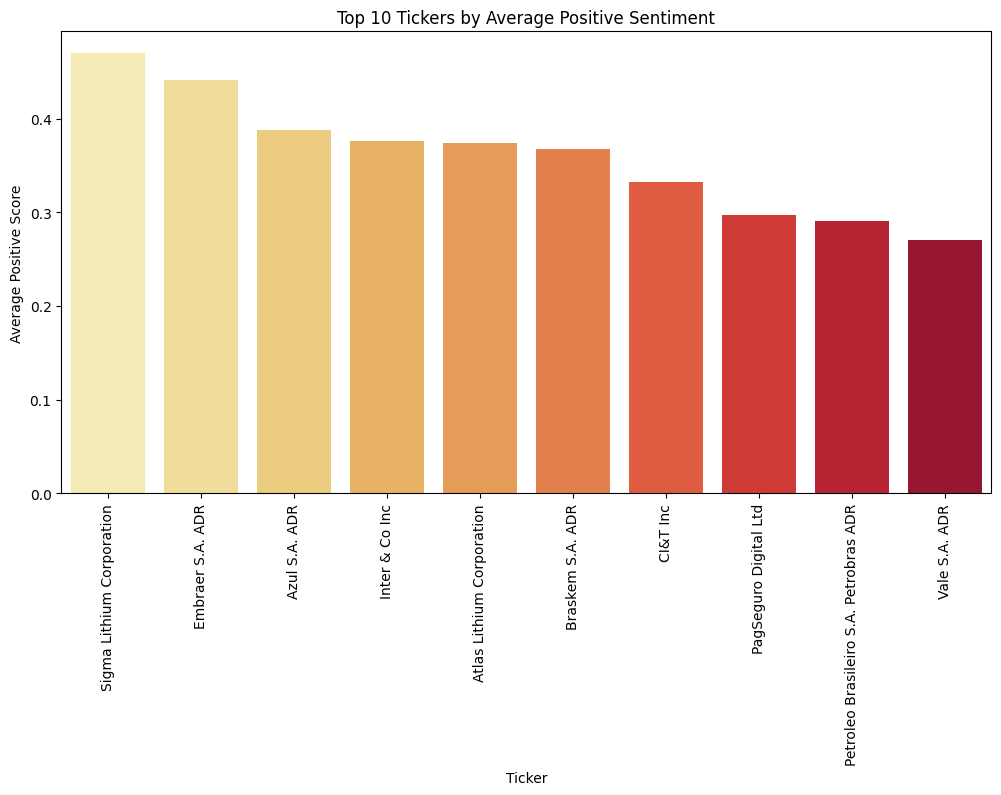

In [12]:
top_positive = results_df.groupby('company')['positive_score'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_positive.index, y=top_positive.values, palette='YlOrRd')
plt.title('Top 10 Tickers by Average Positive Sentiment')
plt.xlabel('Ticker')
plt.ylabel('Average Positive Score')
plt.xticks(rotation=90)
plt.show()


C:\Users\berna\AppData\Local\Temp\ipykernel_17472\3542011153.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_negative.index, y=bottom_negative.values, palette='YlOrRd')


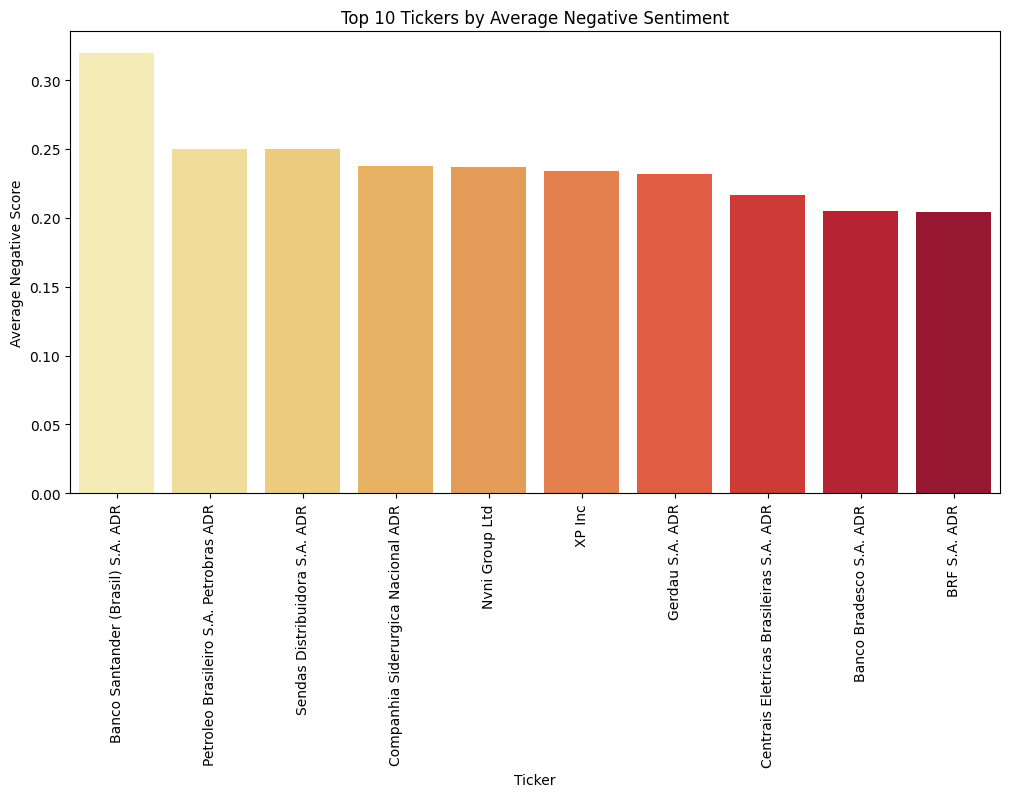

In [13]:
bottom_negative = results_df.groupby('company')['negative_score'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_negative.index, y=bottom_negative.values, palette='YlOrRd')
plt.title('Top 10 Tickers by Average Negative Sentiment')
plt.xlabel('Ticker')
plt.ylabel('Average Negative Score')
plt.xticks(rotation=90)
plt.savefig('top_10_negative_tickers.png')
plt.show()

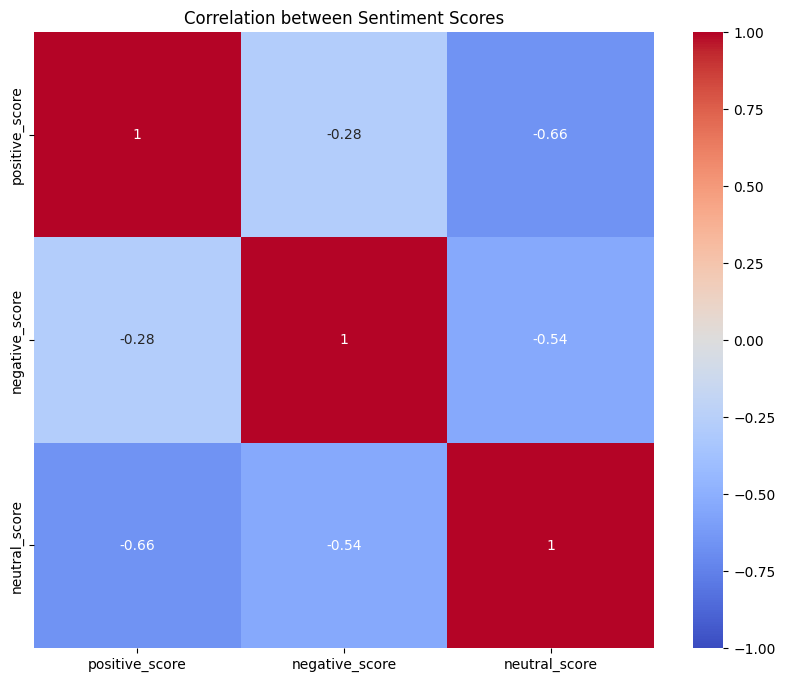

In [14]:
correlation = results_df[['positive_score', 'negative_score', 'neutral_score']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation between Sentiment Scores')
plt.savefig('sentiment_correlation.png')
plt.show()

In [15]:
sentiment_volatility = results_df.groupby('company')[['positive_score', 'negative_score', 'neutral_score']].std()
print("\nTop 5 Tickers by Sentiment Volatility (Standard Deviation of Positive Scores):")
print(sentiment_volatility['positive_score'].nlargest(5))


Top 5 Tickers by Sentiment Volatility (Standard Deviation of Positive Scores):
company
Inter & Co Inc               0.375172
CI&T Inc                     0.367987
Sigma Lithium Corporation    0.367198
Braskem S.A. ADR             0.365037
Embraer S.A. ADR             0.361555
Name: positive_score, dtype: float64
